In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim

# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import gae.gae.optimizer as optimizer
import gae.gae.model
import gae.gae.preprocessing as preprocessing

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN,MiniBatchKMeans,AgglomerativeClustering
from sklearn import metrics

import anndata as ad

In [2]:
inverseAct=True
minCells=15 #min number of cells for analysis
clustermethod=['leiden','dbscan','agglomerative']
#umap/leiden clustering parameters
n_neighbors=10
min_dist=0.25
n_pcs=40 #for clustering
# resolution=[0.5,1,1.5,2]
resolution=[0.05,0.1,0.2,0.3]
plotepoch=9990
savenameAdd=''
#DBscan
epslist= [6,8,10]
min_sampleslist=[15,30,45] 
#agglomerative
nclusterlist=[2,3,4,5,8,10]
aggMetric=['euclidean']

#DE threshold
ntopgene=10 #for plots
fc=1.5
minIngroup=0.2
maxOutgroup=1
pvalthresh=0.05

combineCelltype={'glia':['Astro','Micro', 'OPC', 'Oligo'],'CA':['CA1', 'CA2', 'CA3']}

use_cuda=True
fastmode=False #Validate during training pass
seed=3
useSavedMaskedEdges=False
maskedgeName='knn20_connectivity'
hidden1=1024 #Number of units in hidden layer 1
hidden2=1024 #Number of units in hidden layer 2
# hidden3=16
fc_dim1=1024
# fc_dim2=2112
# fc_dim3=2112
# fc_dim4=2112
# gcn_dim1=2048

dropout=0.01
# randFeatureSubset=None
model_str='gcn_vae_xa_e2_d1_dca'
adj_decodeName=None #gala or None
plot_samples={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
plot_sample_X=['logminmax']
# plot_sample_X=['corrected','scaled']
standardizeX=False
name='allk20XA_01_dca'
logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
modelsavepath='/mnt/xinyi/pamrats/models/train_gae_starmap/'+name
plotsavepath='/mnt/xinyi/pamrats/plots/train_gae_starmap/'+name
    

In [3]:
# Set cuda and seed
np.random.seed(seed)
if use_cuda and (not torch.cuda.is_available()):
    print('cuda not available')
    use_cuda=False
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True


In [4]:
#Load data
savedir=os.path.join('/mnt/xinyi/','starmap')
adj_dir=os.path.join(savedir,'a')

featureslist={}
scaleddata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-raw.h5ad')

scalefactor={}
libsizeSum=0
for s in plot_samples.keys():
    scaleddata_train=scaleddata.X[scaleddata.obs['sample']==plot_samples[s]]

    libsizeS=np.sum(scaleddata_train,axis=1)
    scalefactorS=np.median(libsizeS)
    libsizeSum+=scalefactorS
    scalefactor[s]=scalefactorS
sizeFactor=libsizeSum/len(list(plot_samples.keys()))
for s in plot_samples.keys():
    scaleddata_train=scaleddata.X[scaleddata.obs['sample']==plot_samples[s]]
    
    featurelog_train=np.log2(scaleddata_train*(sizeFactor/scalefactor[s])+1/2)
    featureslist[s+'X_'+plot_sample_X[0]]=torch.tensor(featurelog_train)

feature_names=scaleddata.var.index

In [42]:
def de_singlesample(sample,labels,savepath,feature_names):
    if np.unique(labels).shape[0]==1:
        return
    var = pd.DataFrame(data=feature_names,index=feature_names,columns=['feature_names'])
    obs = pd.DataFrame()
    obs['clusterLabel']=labels
    adata = ad.AnnData(sample, obs=obs.astype('category'),var=var.astype('category'))
    scanpy.tl.rank_genes_groups(adata, 'clusterLabel',use_raw=False, method='wilcoxon',pts=True)
    with open(os.path.join(savepath), 'wb') as output:
        pickle.dump(adata.uns['rank_genes_groups'], output, pickle.HIGHEST_PROTOCOL)
#     scanpy.tl.filter_rank_genes_groups(adata,groupby='clusterLabel',use_raw=False, min_fold_change=fc,min_in_group_fraction=minIngroup,max_out_group_fraction=maxOutgroup)
    genelist=np.array([])
#     print(adata.obs['clusterLabel'])
    for l in np.unique(labels).astype(str):
#         print(l)
        if l==-1:
            continue
        resl=scanpy.get.rank_genes_groups_df(adata, group=l,pval_cutoff=pvalthresh,gene_symbols='feature_names')
#         print(resl)
        resl=resl[np.logical_or(resl['logfoldchanges']>np.log2(fc),resl['logfoldchanges']< -np.log2(fc))]
#         resl=resl[resl['pts']>minIngroup]
        resl=resl.sort_values('pvals_adj',axis=0)
        resl=resl.iloc[:np.min([resl.shape[0],ntopgene]),:]
        genelist=np.concatenate((genelist,resl['names']))
    if genelist.shape[0]==0:
        return
    scanpy.pl.dotplot(adata,genelist,groupby='clusterLabel',use_raw=False,return_fig =True).savefig(savepath+'fc'+str(fc)+'ntop'+str(ntopgene)+'pvalue'+str(pvalthresh)+'.jpg')
    
# def plotEnrichment(clusterlabels,attributelabels,savepath):
#     labels=np.unique(clusterlabels)
#     attributes=np.unique(attributelabels)
    
#     for l in labels:
    
    
#     fig, ax = plt.subplots()

#     ax.bar(labels, men_means, width, yerr=men_std, label='Men')
#     ax.bar(labels, women_means, width, yerr=women_std, bottom=men_means,label='Women')

#     ax.set_ylabel('Scores')
#     ax.set_title('Scores by group and gender')
#     ax.legend()

#     plt.show()
#     return

def deLeiden(sample,n_neighbors,n_pcs,min_dist,resolution,feature_names):
    for r in resolution:
        savenamecluster='leiden_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'n_pcs'+str(n_pcs)+'res'+str(r)+'epoch'+str(plotepoch)
        readpath=os.path.join(clustersavedir,savenamecluster)
        if not os.path.exists(readpath):
            print('DNE: '+readpath)
            continue
        with open(readpath, 'rb') as input:
            labels = pickle.load(input)
        de_singlesample(sample,labels,os.path.join(desavedir,savenamecluster),feature_names)

def deDBscan(sample,epsL,min_samplesL,n_pcs,feature_names):
    for eps in epsL:
        for min_samples in min_samplesL:
            savenamecluster='dbscan_eps'+str(eps)+'msamples'+str(min_samples)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
            readpath=os.path.join(clustersavedir,savenamecluster)
            if not os.path.exists(readpath):
                print('DNE: '+readpath)
                continue
            with open(readpath, 'rb') as input:
                labels = pickle.load(input)
            de_singlesample(sample,labels,os.path.join(desavedir,savenamecluster),feature_names)
                
def deAgg(sample,nclusterL,aggmetricL,n_pcs,feature_names):
    for ncluster in nclusterL:
        for aggmetric in aggmetricL:
            savenamecluster='agg_ncluster'+str(ncluster)+aggmetric+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
            readpath=os.path.join(clustersavedir,savenamecluster)
            if not os.path.exists(readpath):
                print('DNE: '+readpath)
                continue
            with open(readpath, 'rb') as input:
                labels = pickle.load(input)
            de_singlesample(sample,labels,os.path.join(desavedir,savenamecluster),feature_names)
            
def clusterMinibatchKmean(inArray,nclusterL,n_pcs,feature_names):
    for ncluster in nclusterL:
        savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
        readpath=os.path.join(clustersavedir,savenamecluster)
        if not os.path.exists(readpath):
            print('DNE: '+readpath)
            continue
        with open(readpath, 'rb') as input:
            labels = pickle.load(input)
        de_singlesample(sample,labels,os.path.join(desavedir,savenamecluster),feature_names)
                

In [6]:
#all cells
for s in plot_samples.keys():
    sampleidx=plot_samples[s]
    
    celltype_broad=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'top_level']
    celltype_sub=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'cell_type_label']
    region=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'region']
#     sobj_coord_np=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,['x','y']].to_numpy()
    for xcorr in plot_sample_X:
        samplename=s+'X_'+xcorr
        featureDE=np.copy(featureslist[samplename])
        
        if inverseAct:
            samplename+='_beforeAct'
       
        sampledir=os.path.join(plotsavepath,samplename)
        clustersavedir=os.path.join(plotsavepath,samplename,'cluster')
        desavedir=os.path.join(plotsavepath,samplename,'de')
        if not os.path.exists(desavedir):
            os.mkdir(desavedir)
        
        if featureDE.shape[0]<minCells:
            continue
        if 'leiden' in clustermethod:
            deLeiden(featureDE,n_neighbors,n_pcs,min_dist,resolution,feature_names)
        if 'dbscan' in clustermethod:
            deDBscan(featureDE,epslist,min_sampleslist,n_pcs,feature_names)
        if 'agglomerative' in clustermethod:
            deAgg(featureDE,nclusterlist,aggMetric,n_pcs,feature_names)
        if 'kmeanbatch' in clustermethod:
            deMinibatchKmean(featureDE,nclusterlist,n_pcs,feature_names)

/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f2fecbb3f80> (for post_execute):


KeyboardInterrupt: 

control13
CA


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_

/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/xinyiz/anaconda3/envs/pytorch/l

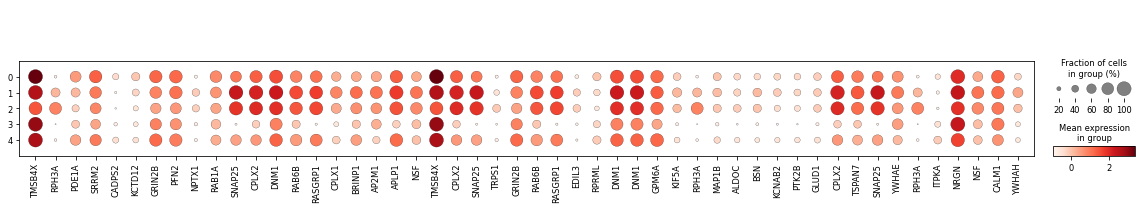

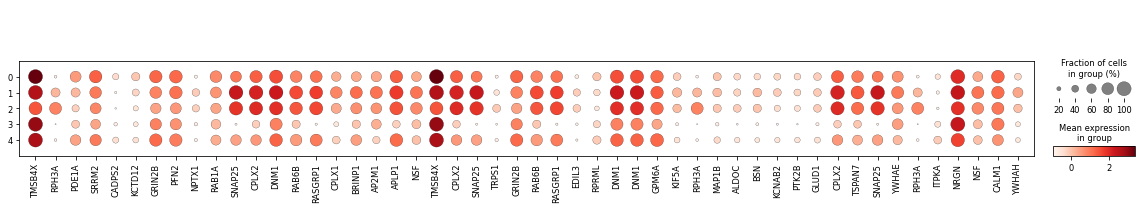

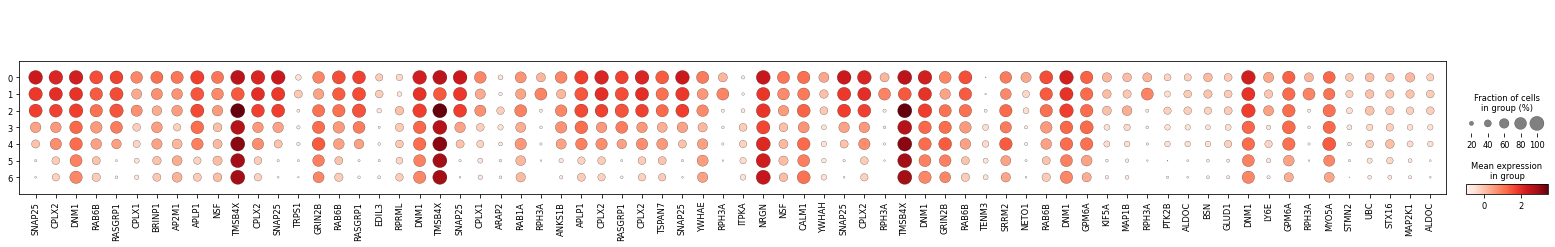

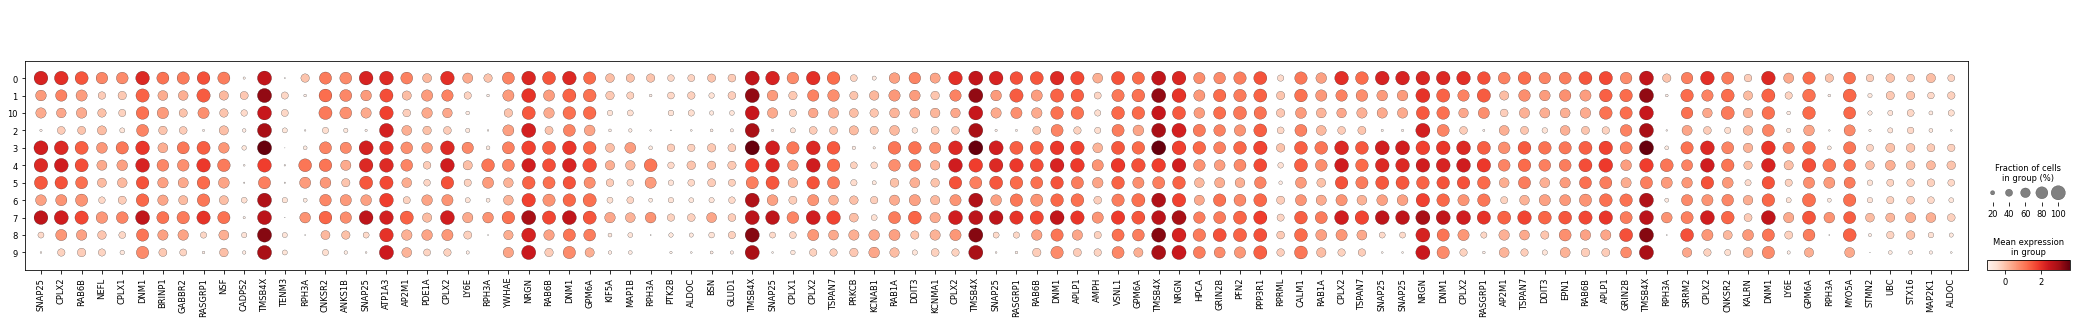

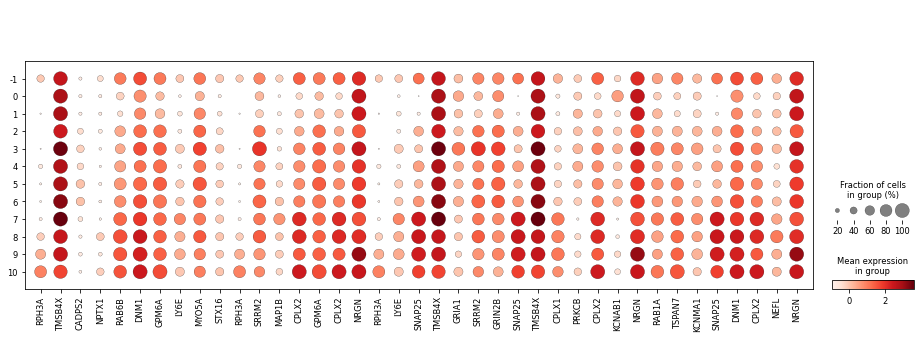

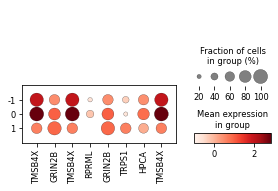

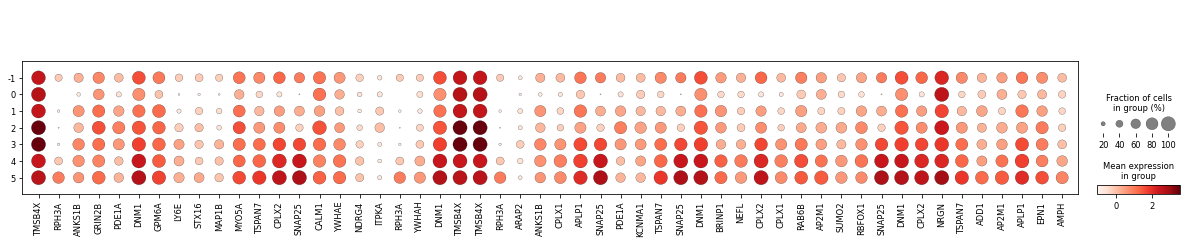

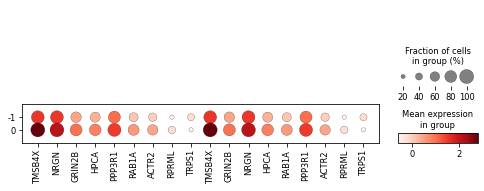

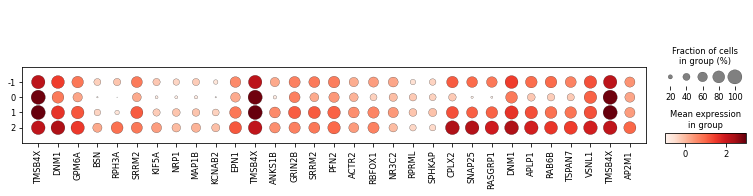

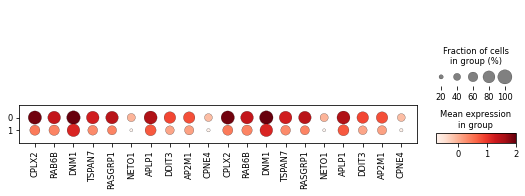

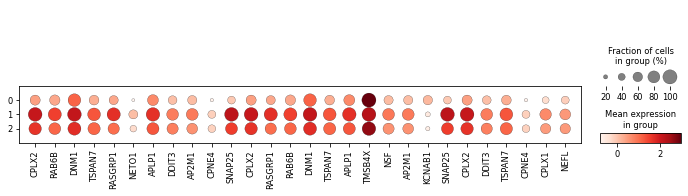

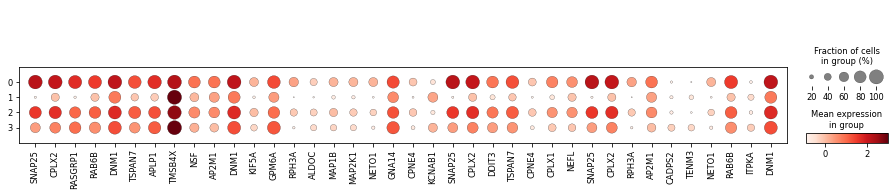

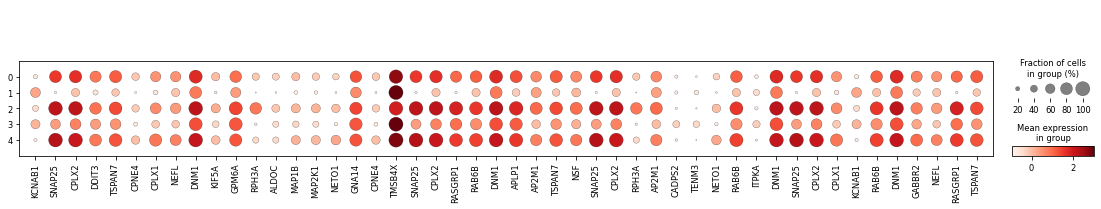

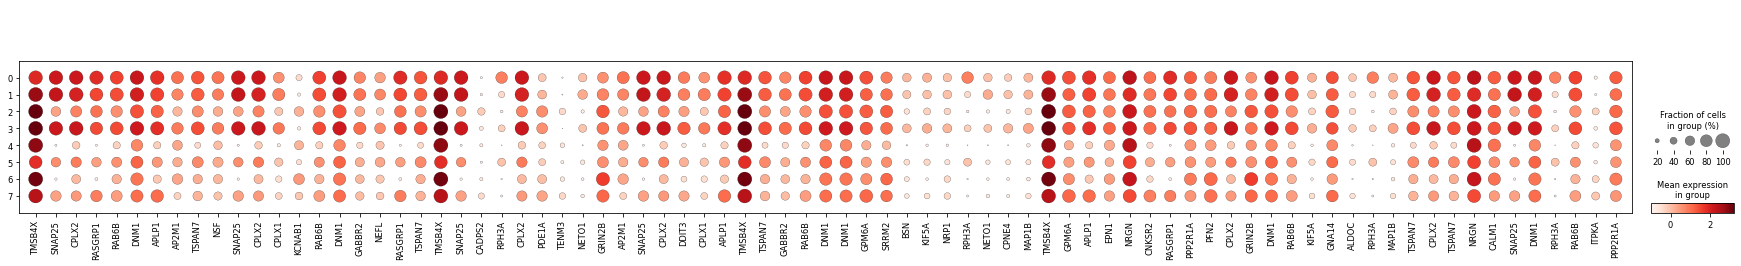

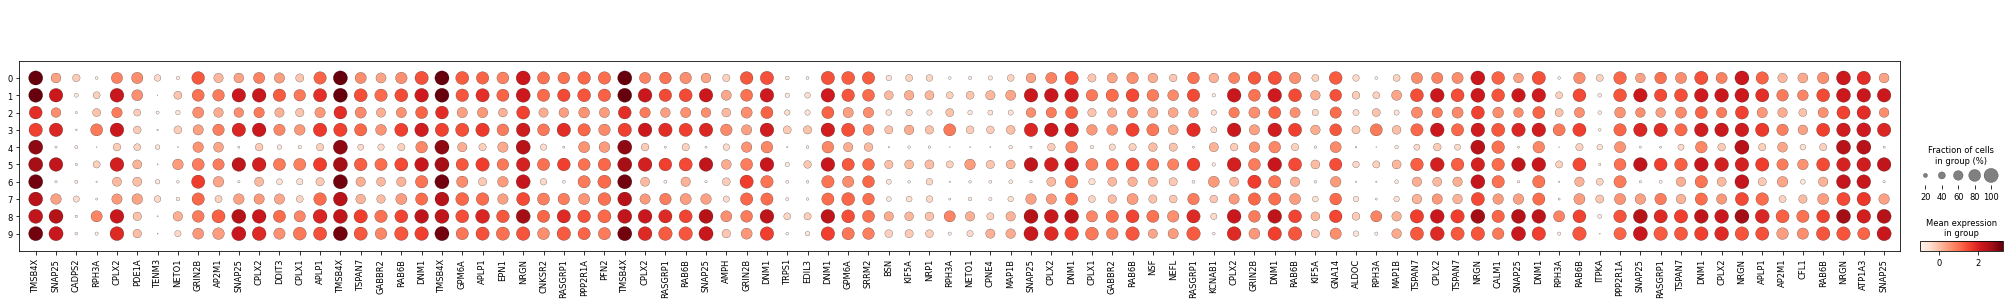

In [56]:
# separate plots by cell type
# for s in plot_samples.keys():
for s in ['control13']:
#     if s =='disease13':
#         continue
    print(s)
    sampleidx=plot_samples[s]
    celltype_broad=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'top_level']
    celltype_sub=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'cell_type_label']
    region=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'region']
#     sobj_coord_np=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,['x','y']].to_numpy()
    
    origCT=np.unique(celltype_broad)
    celltypeplot=np.concatenate((origCT,list(combineCelltype.keys())),axis=None)
    for xcorr in plot_sample_X:
        samplename=s+'X_'+xcorr
        featureDE=np.copy(featureslist[samplename])
        
        if inverseAct:
            samplename+='_beforeAct'
        
        sampledir=os.path.join(plotsavepath,samplename)
        
#         for ct in celltypeplot:
        for ct in ['CA']:
#             if s=='control13' and ct in ['Astro','CA1','CA2','CA3','DG','Endo','Ex','Inhi','LHb','Micro','OPC']:
#                 continue
            print(ct)
            clustersavedir=os.path.join(plotsavepath,samplename,'cluster'+'_'+ct)
            desavedir=os.path.join(plotsavepath,samplename,'de'+'_'+ct)
            if not os.path.exists(desavedir):
                os.mkdir(desavedir)
            
            if ct in origCT:
                ct_idx=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'top_level']==ct
            else:
                ct_idx=False
                for i in combineCelltype[ct]:
                    ct_idx=np.logical_or(ct_idx,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'top_level']==i)
                    
            if np.sum(ct_idx)<minCells:
                continue
            if 'leiden' in clustermethod:
                deLeiden(featureDE[ct_idx],n_neighbors,n_pcs,min_dist,resolution,feature_names)
            if 'dbscan' in clustermethod:
                deDBscan(featureDE[ct_idx],epslist,min_sampleslist,n_pcs,feature_names)
            if 'agglomerative' in clustermethod:
                deAgg(featureDE[ct_idx],nclusterlist,aggMetric,n_pcs,feature_names)
            if 'kmeanbatch' in clustermethod:
                deMinibatchKmean(featureDE[ct_idx],nclusterlist,n_pcs,feature_names)

In [ ]:
# separate plots by region
for s in plot_samples.keys():
    sampleidx=plot_samples[s]
    celltype_broad=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'top_level']
    celltype_sub=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'cell_type_label']
    region=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'region']
    sobj_coord_np=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,['x','y']].to_numpy()
    for xcorr in plot_sample_X:
        samplename=s+'X_'+xcorr
        muplot=np.copy(mulist[samplename])
        
        if inverseAct:
            samplename+='_beforeAct'
        sampledir=os.path.join(plotsavepath,samplename)
        if not os.path.exists(sampledir):
            os.mkdir(sampledir)
        
        for reg in np.unique(region):
            savedir=os.path.join(plotsavepath,samplename,'embedding_'+plottype+'_'+reg)
            clustersavedir=os.path.join(plotsavepath,samplename,'cluster'+'_'+reg)
            if not os.path.exists(savedir):
                os.mkdir(savedir)
            if not os.path.exists(clustersavedir):
                os.mkdir(clustersavedir)
            
            reg_idx=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'region']==reg
            
            if plottype=='umap':
                reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed)
                embedding = reducer.fit_transform(muplot[reg_idx])
                savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'epoch'+str(plotepoch)
            elif plottype=='pca':
                embedding=pca.fit_transform(muplot[reg_idx])
                savenameAdd='_epoch'+str(plotepoch)
                
            if ifplot:
                plotembeddingbyCT(celltype_broad[reg_idx],'celltype_broad',[],embedding,savedir,plottype+' of '+s+' '+reg,savenameAdd=savenameAdd)
                plotembeddingbyCT(celltype_sub[reg_idx],'celltype_sub',[],embedding,savedir,plottype+' of '+s+' '+reg,savenameAdd=savenameAdd)
    #             plotembeddingbyCT(region,'region',[],embedding[reg_idx],savedir,'UMAP of '+s)

                plotembeddingbyCT_contrast(celltype_sub[reg_idx],'celltype_sub',[],embedding,os.path.join(savedir,'contrast'),plottype+' of '+s+' '+reg,savenameAdd=savenameAdd)
            
            if embedding.shape[0]<minCells:
                continue
            if ifcluster:
                if 'leiden' in clustermethod:
                    clusterLeiden(muplot[reg_idx],n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np[reg_idx],randseed=seed)
                if 'dbscan' in clustermethod:
                    clusterDBscan(muplot[reg_idx],epslist,min_sampleslist,n_pcs,sobj_coord_np[reg_idx])
                if 'agglomerative' in clustermethod:
                    clusterAgg(muplot[reg_idx],nclusterlist,aggMetric,n_pcs,sobj_coord_np[reg_idx])

/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplac

DNE: /mnt/xinyi/pamrats/plots/train_gae_starmap/allk20XA_01_dca/combinedlogminmax_beforeAct/cluster_CortexEx/leiden_nn10mdist025n_pcs40res0.2epoch9990
DNE: /mnt/xinyi/pamrats/plots/train_gae_starmap/allk20XA_01_dca/combinedlogminmax_beforeAct/cluster_CortexEx/leiden_nn10mdist025n_pcs40res0.3epoch9990
DNE: /mnt/xinyi/pamrats/plots/train_gae_starmap/allk20XA_01_dca/combinedlogminmax_beforeAct/cluster_CortexEx/dbscan_eps6msamples15n_pcs40epoch9990
DNE: /mnt/xinyi/pamrats/plots/train_gae_starmap/allk20XA_01_dca/combinedlogminmax_beforeAct/cluster_CortexEx/dbscan_eps6msamples30n_pcs40epoch9990
DNE: /mnt/xinyi/pamrats/plots/train_gae_starmap/allk20XA_01_dca/combinedlogminmax_beforeAct/cluster_CortexEx/dbscan_eps6msamples45n_pcs40epoch9990
DNE: /mnt/xinyi/pamrats/plots/train_gae_starmap/allk20XA_01_dca/combinedlogminmax_beforeAct/cluster_CortexEx/dbscan_eps8msamples15n_pcs40epoch9990
DNE: /mnt/xinyi/pamrats/plots/train_gae_starmap/allk20XA_01_dca/combinedlogminmax_beforeAct/cluster_CortexEx/d

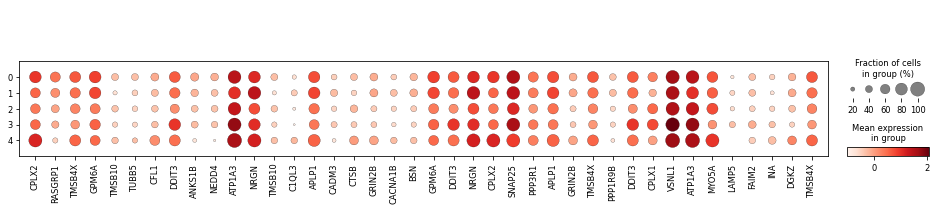

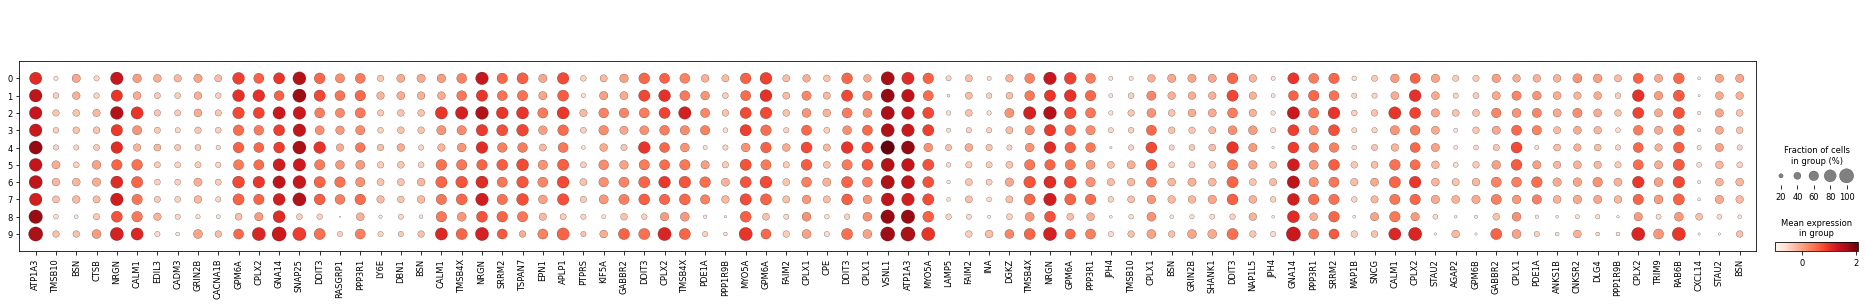

In [54]:
# combine all latents to one plot 
for xcorr in plot_sample_X:
    celltype_broad=None
    celltype_sub=None
    region=None
#     samplenameList=None
    featureDE=None
#     sobj_coord_np=None
    
    for s in plot_samples.keys():
        sampleidx=plot_samples[s]        
        samplename=s+'X_'+xcorr
        featureDEs=np.copy(featureslist[samplename])
            
        if featureDE is None:
            featureDE=featureDEs
            celltype_broad=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'top_level']
            celltype_sub=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'cell_type_label']
            region=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'region']
#             sobj_coord_np=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,['x','y']].to_numpy()
#             samplenameList=np.repeat(s,muplot.shape[0])
        else:
            featureDE=np.vstack((featureDE,featureDEs))
            celltype_broad=np.concatenate((celltype_broad,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'top_level']),axis=None)
            celltype_sub=np.concatenate((celltype_sub,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'cell_type_label']),axis=None)
            region=np.concatenate((region,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'region']),axis=None)
#             sobj_coord_np=np.concatenate((sobj_coord_np,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,['x','y']].to_numpy()),axis=0)
#             samplenameList=np.concatenate((samplenameList,np.repeat(s,muplot.shape[0])),axis=None)
       
    origCT=np.unique(celltype_broad)
    celltypeplot=np.concatenate((origCT,list(combineCelltype.keys())),axis=None)
    sampledir=os.path.join(plotsavepath,'combined'+xcorr)
    if inverseAct:
        sampledir+='_beforeAct'
#     savedir=os.path.join(sampledir,'embedding_'+plottype)
#     clustersavedir=os.path.join(sampledir,'cluster')
#     if not os.path.exists(sampledir):
#         os.mkdir(sampledir)
#     if not os.path.exists(savedir):
#         os.mkdir(savedir)
#     if not os.path.exists(clustersavedir):
#         os.mkdir(clustersavedir)
    
    
#     if embedding.shape[0]<minCells:
#         continue
#     if ifcluster:
#         if 'leiden' in clustermethod:
#             clusterLeiden_allsample(latents,n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np,samplenameList,randseed=seed)
#         if 'dbscan' in clustermethod:
#             clusterDBscan_allsample(latents,epslist,min_sampleslist,n_pcs,sobj_coord_np,samplenameList)
#         if 'agglomerative' in clustermethod:
#             clusterAgg_allsample(latents,nclusterlist,aggMetric,n_pcs,sobj_coord_np,samplenameList)
    #by region
#     for reg in np.unique(region):
    for reg in ['Cortex']:
#         savedir=os.path.join(sampledir,'embedding_'+plottype+'_'+reg)
#         clustersavedir=os.path.join(sampledir,'cluster'+'_'+reg)
#         if not os.path.exists(savedir):
#             os.mkdir(savedir)
#         if not os.path.exists(clustersavedir):
#             os.mkdir(clustersavedir)

        reg_idx=region==reg

        
#         if embedding.shape[0]<minCells:
#             continue
#         if ifcluster:
#             if 'leiden' in clustermethod:
#                 clusterLeiden_allsample(latents[reg_idx],n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np[reg_idx],samplenameList[reg_idx],randseed=seed)
#             if 'dbscan' in clustermethod:
#                 clusterDBscan_allsample(latents[reg_idx],epslist,min_sampleslist,n_pcs,sobj_coord_np[reg_idx],samplenameList[reg_idx])
#             if 'agglomerative' in clustermethod:
#                 clusterAgg_allsample(latents[reg_idx],nclusterlist,aggMetric,n_pcs,sobj_coord_np[reg_idx],samplenameList[reg_idx])
                    
        #by region and celltype
#         for ct in celltypeplot:
        for ct in ['Ex']:
            clustersavedir=os.path.join(sampledir,'cluster'+'_'+reg+ct)
            desavedir=os.path.join(sampledir,'de'+'_'+reg+ct)
            if not os.path.exists(desavedir):
                os.mkdir(desavedir)

            
            if ct in origCT:
                ct_idx=celltype_broad==ct
            else:
                ct_idx=False
                for i in combineCelltype[ct]:
                    ct_idx=np.logical_or(ct_idx,celltype_broad==i)
            ct_idx=np.logical_and(reg_idx,ct_idx)      
            
            if np.sum(ct_idx)<minCells:
                continue
            if 'leiden' in clustermethod:
                deLeiden(featureDE[ct_idx],n_neighbors,n_pcs,min_dist,resolution,feature_names)
            if 'dbscan' in clustermethod:
                deDBscan(featureDE[ct_idx],epslist,min_sampleslist,n_pcs,feature_names)
            if 'agglomerative' in clustermethod:
                deAgg(featureDE[ct_idx],nclusterlist,aggMetric,n_pcs,feature_names)
            if 'kmeanbatch' in clustermethod:
                deMinibatchKmean(featureDE[ct_idx],nclusterlist,n_pcs,feature_names)
    #by celltype
#     for ct in celltypeplot:
#         savedir=os.path.join(sampledir,'embedding_'+plottype+'_'+ct)
#         clustersavedir=os.path.join(sampledir,'cluster'+'_'+ct)
#         if not os.path.exists(savedir):
#             os.mkdir(savedir)
#         if not os.path.exists(clustersavedir):
#             os.mkdir(clustersavedir)

#         if ct in origCT:
#             ct_idx=celltype_broad==ct
#         else:
#             ct_idx=False
#             for i in combineCelltype[ct]:
#                 ct_idx=np.logical_or(ct_idx,celltype_broad==i)

        
#         if embedding.shape[0]<minCells:
#             continue
#         if ifcluster:
#             if 'leiden' in clustermethod:
#                 clusterLeiden_allsample(latents[ct_idx],n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np[ct_idx],samplenameList[ct_idx],randseed=seed)
#             if 'dbscan' in clustermethod:
#                 clusterDBscan_allsample(latents[ct_idx],epslist,min_sampleslist,n_pcs,sobj_coord_np[ct_idx],samplenameList[ct_idx])
#             if 'agglomerative' in clustermethod:
#                 clusterAgg_allsample(latents[ct_idx],nclusterlist,aggMetric,n_pcs,sobj_coord_np[ct_idx],samplenameList[ct_idx])

disease13
Cortex
Astro


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_

CA1
CA2
CA3
DG
Endo


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to

Ex


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_

/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplac

Inhi


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to

LHb
Micro


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to

OPC


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to

Oligo


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_

SMC


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to

Hippocampus
Astro


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_

CA1


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_

/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


CA2


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to

CA3


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_

/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_

DG


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_

/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplac

Endo


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to

Ex


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to

Inhi


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_

LHb
Micro


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to

OPC


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


DNE: /mnt/xinyi/pamrats/plots/train_gae_starmap/allk20XA_01_dca/disease13X_logminmax_beforeAct/cluster_OPC/Hippocampus/dbscan_eps10msamples45n_pcs40epoch9990
DNE: /mnt/xinyi/pamrats/plots/train_gae_starmap/allk20XA_01_dca/disease13X_logminmax_beforeAct/cluster_OPC/Hippocampus/agg_ncluster2euclideann_pcs40epoch9990
DNE: /mnt/xinyi/pamrats/plots/train_gae_starmap/allk20XA_01_dca/disease13X_logminmax_beforeAct/cluster_OPC/Hippocampus/agg_ncluster3euclideann_pcs40epoch9990
DNE: /mnt/xinyi/pamrats/plots/train_gae_starmap/allk20XA_01_dca/disease13X_logminmax_beforeAct/cluster_OPC/Hippocampus/agg_ncluster4euclideann_pcs40epoch9990
DNE: /mnt/xinyi/pamrats/plots/train_gae_starmap/allk20XA_01_dca/disease13X_logminmax_beforeAct/cluster_OPC/Hippocampus/agg_ncluster5euclideann_pcs40epoch9990
DNE: /mnt/xinyi/pamrats/plots/train_gae_starmap/allk20XA_01_dca/disease13X_logminmax_beforeAct/cluster_OPC/Hippocampus/agg_ncluster8euclideann_pcs40epoch9990
DNE: /mnt/xinyi/pamrats/plots/train_gae_starmap/allk

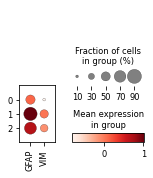

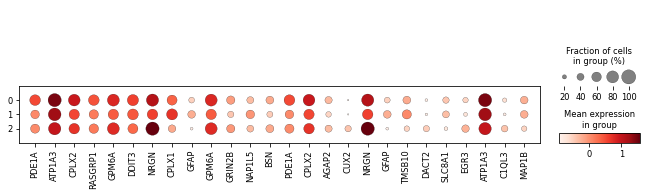

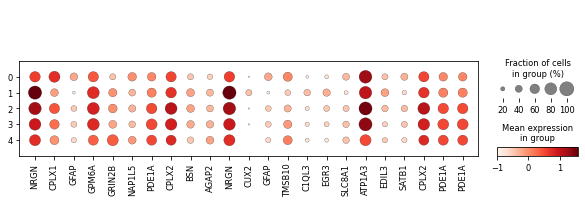

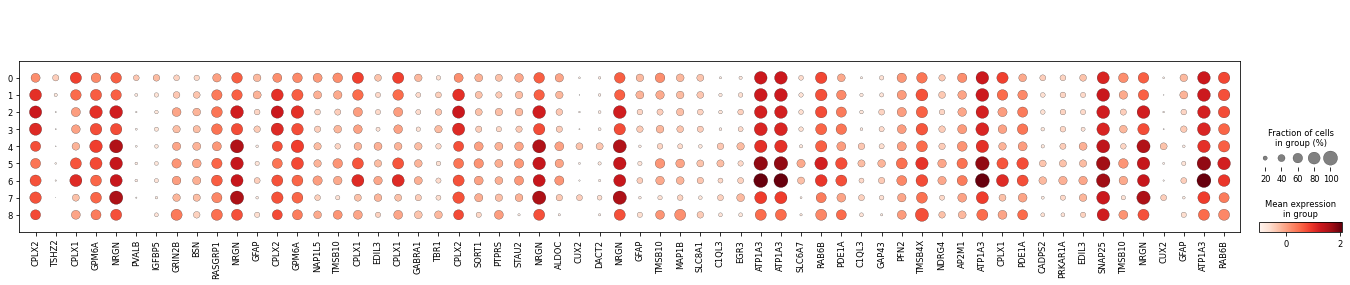

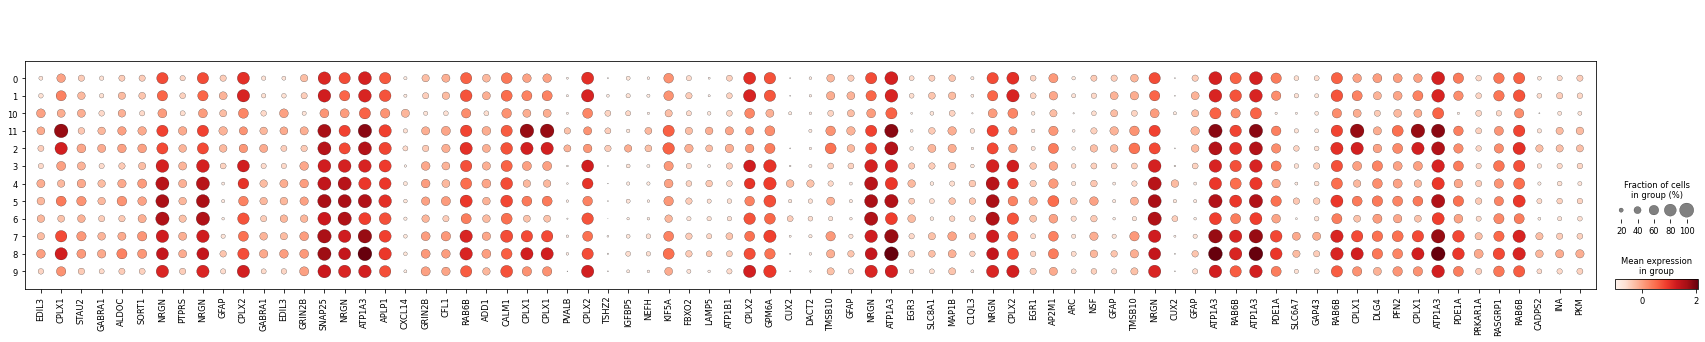

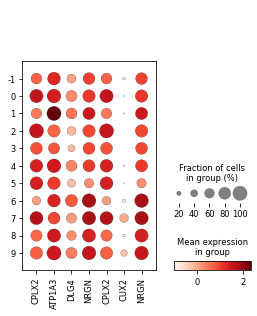

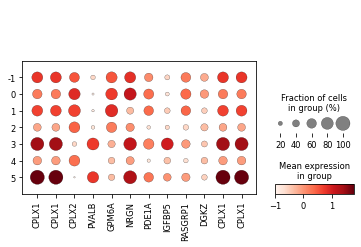

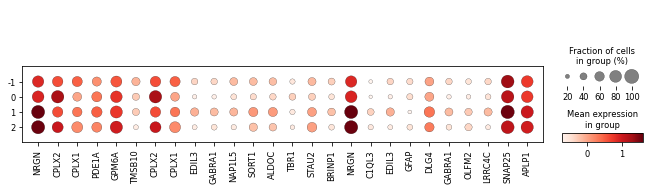

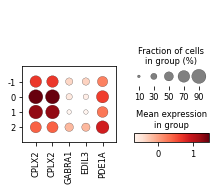

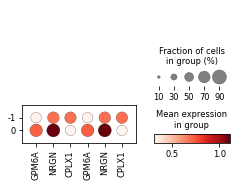

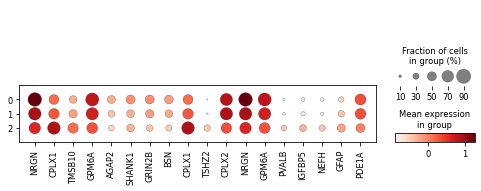

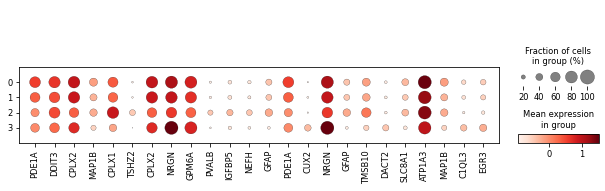

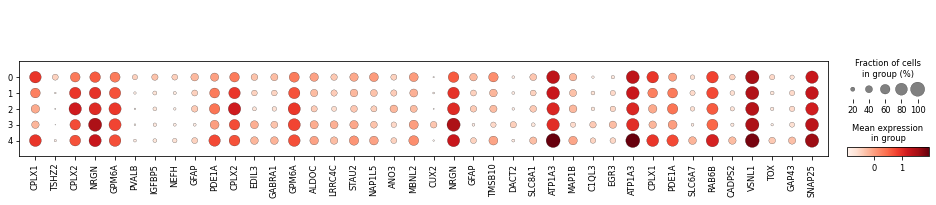

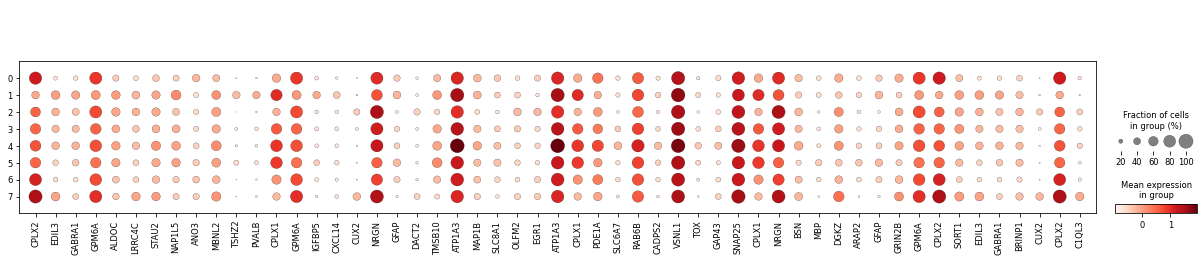

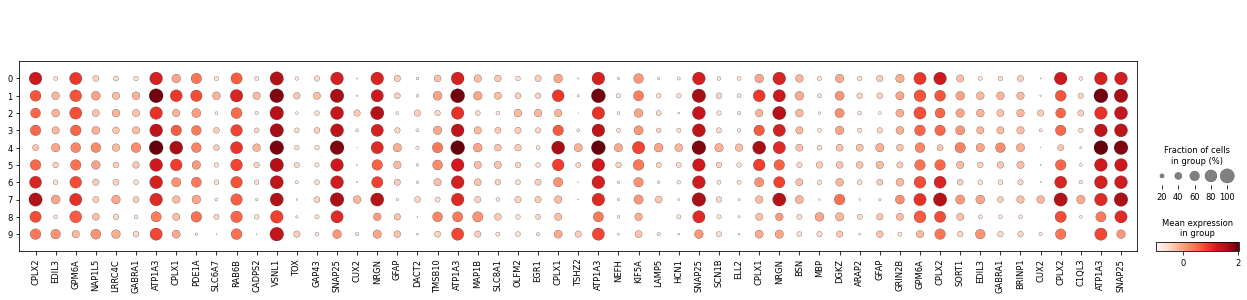

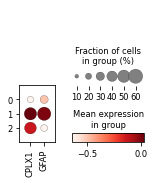

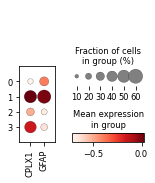

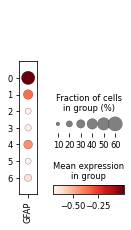

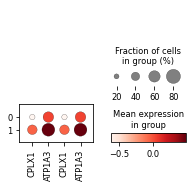

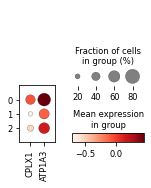

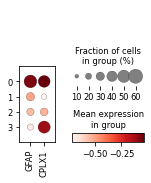

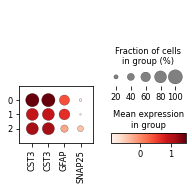

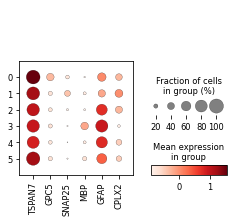

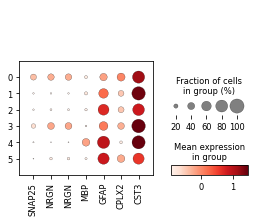

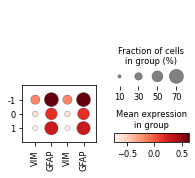

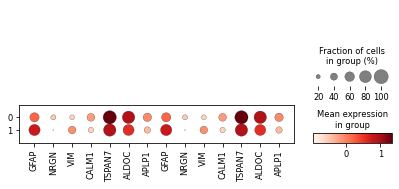

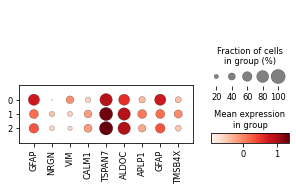

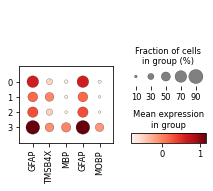

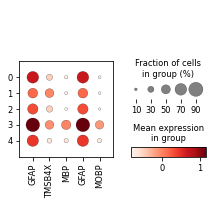

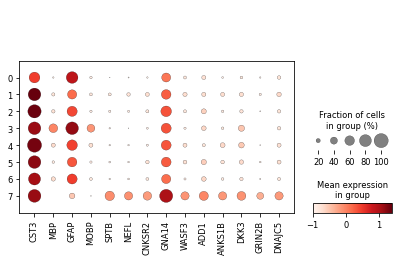

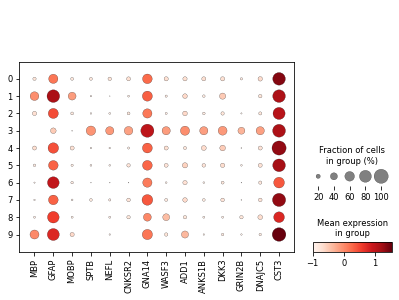

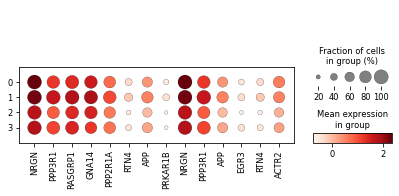

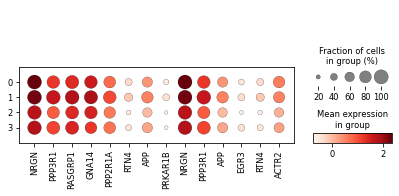

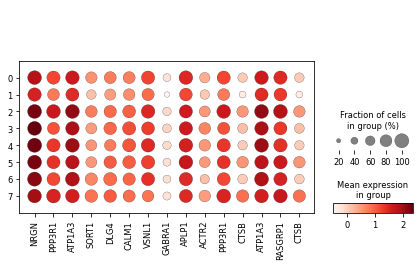

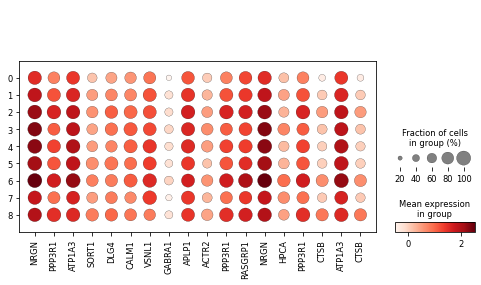

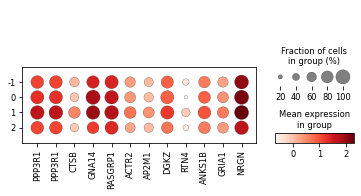

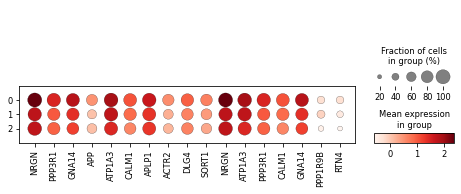

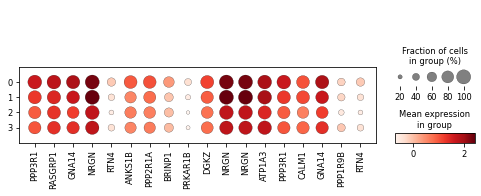

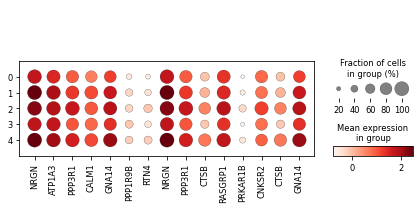

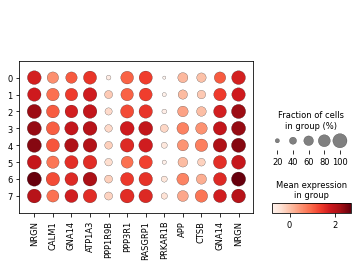

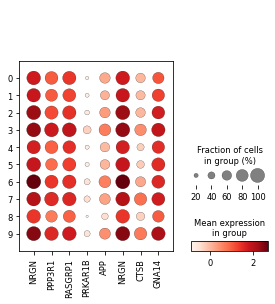

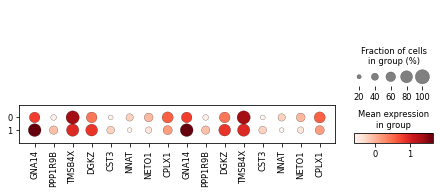

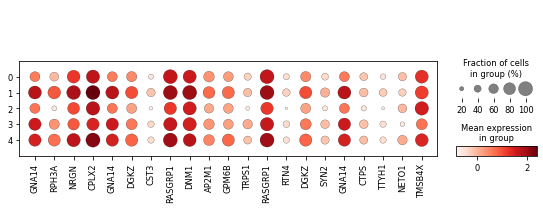

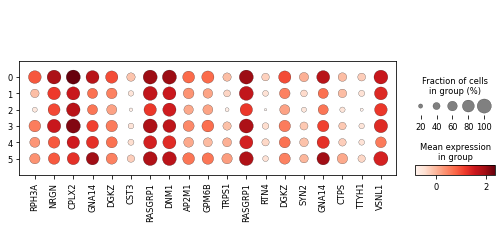

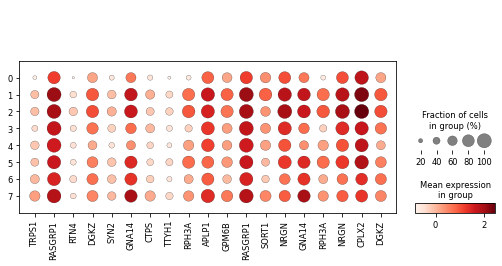

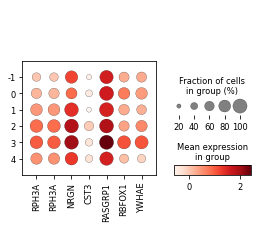

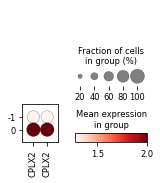

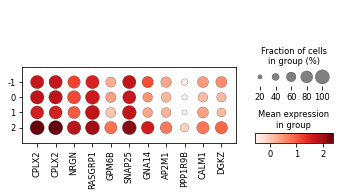

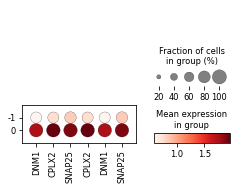

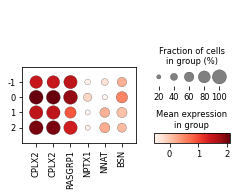

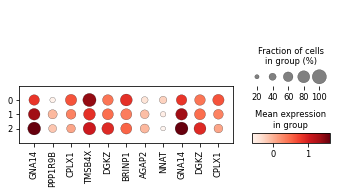

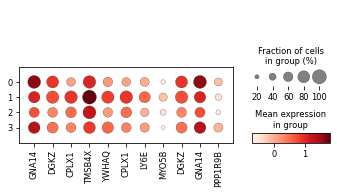

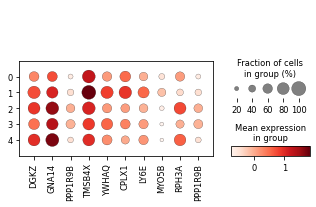

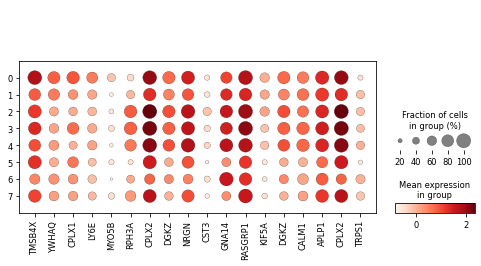

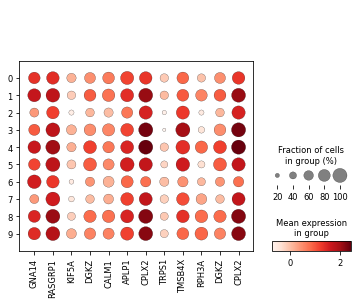

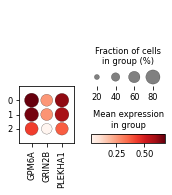

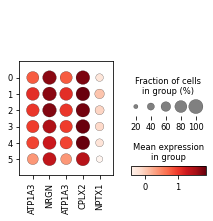

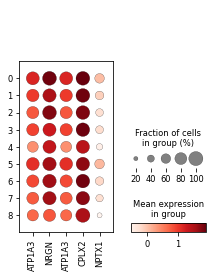

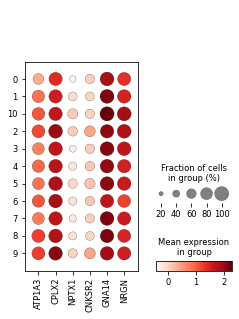

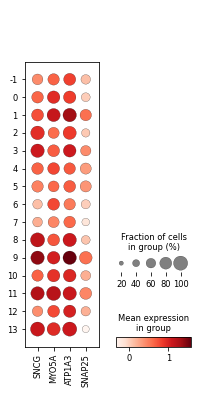

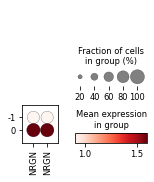

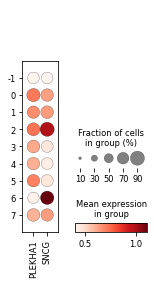

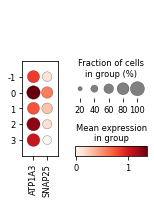

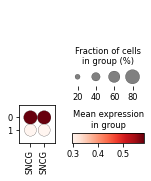

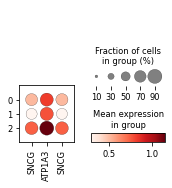

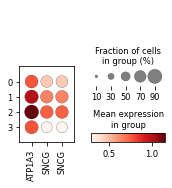

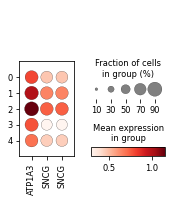

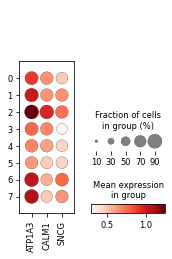

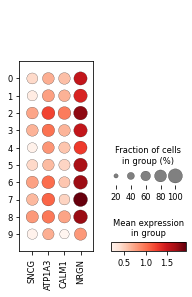

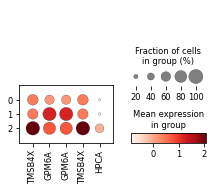

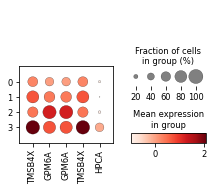

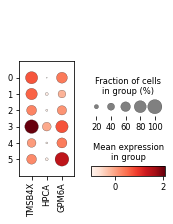

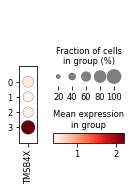

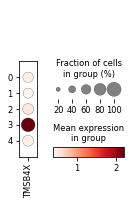

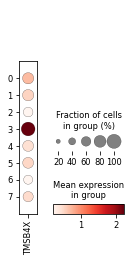

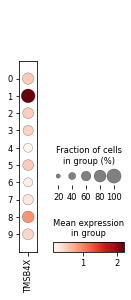

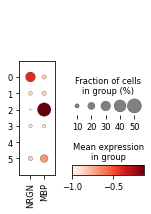

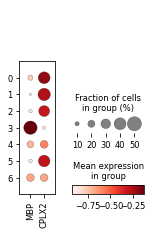

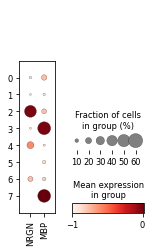

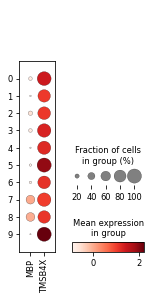

In [51]:
# separate plots by region and cell types
# for s in plot_samples.keys():
for s in ['disease13']:
    print(s)
    sampleidx=plot_samples[s]
    celltype_broad=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'top_level']
    celltype_sub=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'cell_type_label']
    region=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'region']
#     sobj_coord_np=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,['x','y']].to_numpy()
    
    origCT=np.unique(celltype_broad)
    celltypeplot=np.concatenate((origCT,list(combineCelltype.keys())),axis=None)
    for xcorr in plot_sample_X:
        samplename=s+'X_'+xcorr
        featureDE=np.copy(featureslist[samplename])

        if inverseAct:
            samplename+='_beforeAct'
        sampledir=os.path.join(plotsavepath,samplename)
        if not os.path.exists(sampledir):
            os.mkdir(sampledir)
            
        for r in np.unique(region):
            if r=='White Matter':
                continue
            print(r)
            ridx=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'region']==r
            for reg in np.unique(celltype_broad):
                print(reg)
                clustersavedir=os.path.join(plotsavepath,samplename,'cluster'+'_'+reg,r)
                desavedir=os.path.join(plotsavepath,samplename,'de'+'_'+reg+r)
                if not os.path.exists(desavedir):
                    os.mkdir(desavedir)

                if reg in origCT:
                    ct_idx=celltype_broad==reg
                else:
                    ct_idx=False
                    for i in combineCelltype[reg]:
                        ct_idx=np.logical_or(ct_idx,celltype_broad==i)
                
                reg_idx=np.logical_and(ridx,ct_idx)
                
                        
                if np.sum(reg_idx)<minCells:
                    continue
                if 'leiden' in clustermethod:
                    deLeiden(featureDE[reg_idx],n_neighbors,n_pcs,min_dist,resolution,feature_names)
                if 'dbscan' in clustermethod:
                    deDBscan(featureDE[reg_idx],epslist,min_sampleslist,n_pcs,feature_names)
                if 'agglomerative' in clustermethod:
                    deAgg(featureDE[reg_idx],nclusterlist,aggMetric,n_pcs,feature_names)
                if 'kmeanbatch' in clustermethod:
                    deMinibatchKmean(featureDE[reg_idx],nclusterlist,n_pcs,feature_names)